# Six-bar mechanism balancing

###### Luis Eduardo Robles Jiménez

With this work, I pretend to find out the behavior of the function with different tools, in order to understand what are the most important variables, find patterns, identify overlapping zones of minima between the functions we're optimizing, graphing data, etc.

In [1]:
from BetaShF import *
from BetaShM import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import scipy as sp
import time


assert ShF([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) == 1.0
assert ShM([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) == 1.0

#### Constraints

$$ -0.16m \leq x_{cn}, y_{cn} \leq 0.16m $$

$$ 0.005m \leq t_{cn} \leq 0.04m $$

#### Objective function

In [ ]:
def objective(s, ShF, ShM):
    return 0.5*ShF(s) + 0.5*ShM(s)

## Mathematical analysis with sympy

## Sample generation

In [ ]:
nSamples, nVariables = 250, 15
samples = np.zeros((nSamples, nVariables))
bounds = np.zeros((nVariables, 2))
fitness = np.zeros((nSamples))
"""
for i in range(nVariables):
    if (i + 1) % 3 == 0: samples[:, i] = np.random.uniform(0.005, 0.04, (nSamples))
    else: samples[:, i] = np.random.uniform(-0.16, 0.16, (nSamples))
"""
for v in range(nVariables):
    bounds[v] = [0.005, 0.04] if (v + 1) % 3 == 0 else [-0.16, 0.16]
worst = 0.0
for s in range(nSamples):
    print("\rIteration:", s, "\tWorst fitness:", worst, end = "")
    r = sp.optimize.differential_evolution(objective, bounds, args = (ShF, ShM), maxiter = 10)
    samples[s] = r.x
    fitness[s] = r.fun
    worst = np.max([worst, fitness[s]])

### Write data to a file

In [ ]:
now = str(int(time.time()))
np.savetxt(now + "Population.txt", samples)
np.savetxt(now + "Fitness.txt", fitness)

### Read data from a file

In [2]:
fitness = np.loadtxt("1671649703Fitness.txt")
samples = np.loadtxt("1671649703Population.txt")

## Dimensionality reduction

### Feature extraction

### Feature selection

In [3]:
modelPCA = PCA()
modelPCA.fit(samples)
dataPCA = modelPCA.transform(samples)
dataPCA.shape

(250, 15)

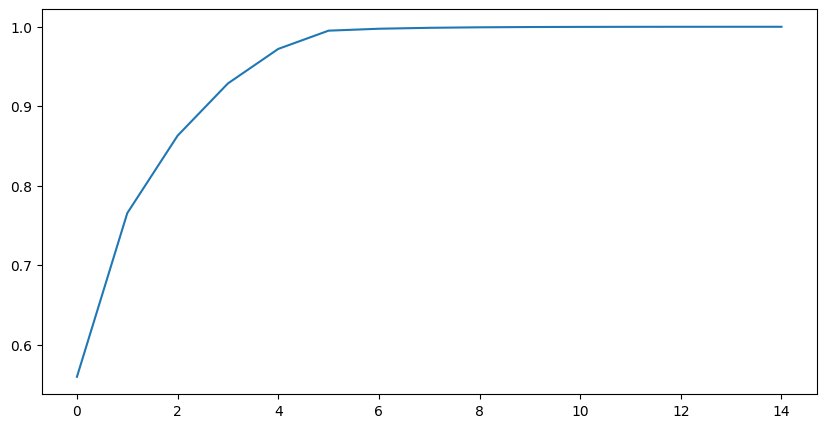

In [4]:
expVar = modelPCA.explained_variance_ratio_
expVarCum = np.cumsum(expVar)
plt.figure(figsize=(10, 5))
plt.plot(expVarCum)
plt.show()

## Data visualization

### First two main components

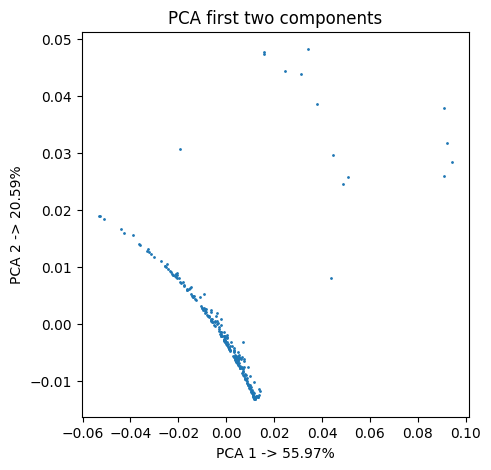

In [79]:
dataPCA = dataPCA[:, :2]
plt.figure(figsize=(5, 5))
plt.title("PCA first two components")
plt.scatter(dataPCA[:, 0], dataPCA[:, 1], s = 1)
plt.xlabel("PCA 1 -> " + str(np.round(expVar[0]*100, 2)) + "%")
plt.ylabel("PCA 2 -> " + str(np.round(expVar[1]*100, 2)) + "%")
plt.show()

### Parallel coordinates 

In [78]:
fig = px.parallel_coordinates(samples, title = "Mechanism balancing samples",
                            color = fitness,
                            labels=["x One", "y One", "t One", "x Two", "y Two", "t Two", "x Three", "y Three", "t Three", "x Four", "y Four", "t Four", "x Five", "y Five", "t Five", "Fitness"],
                            color_continuous_scale=px.colors.sequential.Hot)
fig.show()

### Boxplot

Creating this graph with hopes of seeing if the masses are similar among the good solutions. 

And maybe conclude that the heavier a weight is, the more important it is.

The mass can be easily calculated with the given information.

#### Formula

$$\sigma_i = \frac{m_i}{V_i}$$

$$m_i = V_i \sigma_i$$

$$m_i = (r_i^2 t_i \pi)(\sigma_i)$$

$$m_i = (\sqrt{x_i^2 + y_i^2}^2 t_i \pi)(\sigma_i)$$

$$m_i = (x_i^2 + y_i^2) t_i \pi\sigma_i$$

#### Considering that

$\sigma$ is density. In this problem: $\sigma_i = 7800 \frac{kg}{m^3}$

$m$ is mass $(kg)$

$V$ is volume $(m^3)$

$x, y$ are the relative coordinates of the weight centers. $(m)$

0 1 2
[-22.8  -9.5  -2.   -0.8  -0.   -0.   -0.    0.    0.    0.    0.    0.1
   1.7   3.1]
T [-0.1 -0.1 -0.  -0.  -0.  -0.  -0.   0.   0.   0.   0.   0.   0.   0. ]
3 4 5
[-22.6  -9.5  -2.   -0.8  -0.   -0.    0.    0.    0.    0.    0.    0.
   2.    3.1]
T [-0.1 -0.1 -0.  -0.  -0.  -0.   0.   0.   0.   0.   0.   0.   0. ]
6 7 8
[-52.3  -9.5  -2.   -0.8  -0.1  -0.   -0.    0.    0.    0.    0.    0.2
   0.5   3.1]
T [-0.1 -0.1 -0.  -0.  -0.  -0.  -0.   0.   0.   0.   0.   0.   0.   0. ]
9 10 11
[-26.5  -9.2  -1.   -0.4  -0.1  -0.   -0.    0.    0.    0.    0.1   0.1
   0.4   1.6   3.1]
T [-0.1 -0.1 -0.  -0.  -0.  -0.  -0.   0.   0.   0.   0.   0.   0. ]
12 13 14
[-31.1  -9.5  -2.   -0.8  -0.   -0.    0.    0.    0.    0.    0.    0.3
   0.9   3.1]
T [-0.1 -0.1 -0.  -0.  -0.  -0.   0.   0.   0.   0.   0.   0.   0.   0. ]


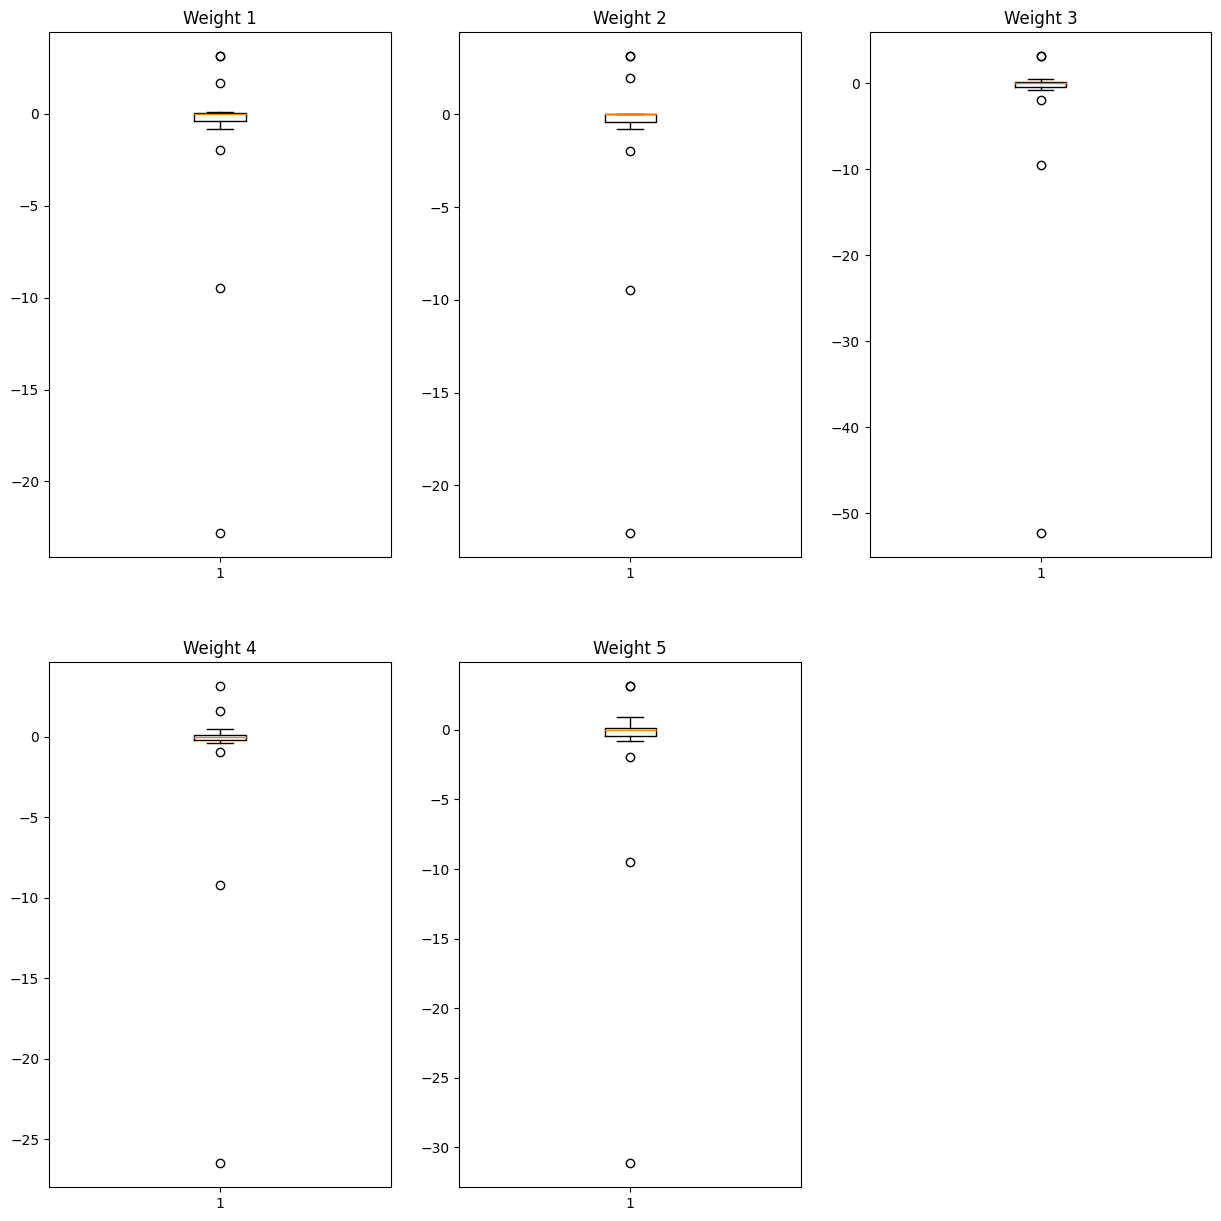

In [91]:
density = 7800
fig = plt.figure(figsize =(15, 15))
for i in range(5):
    print(i*3, i*3 + 1, i*3 + 2)
    plt.subplot(2, 3, i + 1)
    plt.title("Weight " + str(i + 1))
    masses = (samples[i*3]**2 + samples[i*3 + 1]**2) * samples[i*3 + 2] * np.pi * density
    print(np.round(np.unique(masses), 1))
    print("T", np.round(np.unique(samples[i*3 + 2]), 1))
    plt.boxplot(masses)
"""
plt.subplot(2, 3, 1)
plt.boxplot((samples[0]**2 + samples[1]**2) * samples[2] * np.pi * density)
plt.subplot(2, 3, 2)
plt.subplot(2, 3, 3)
plt.subplot(2, 3, 4)
plt.subplot(2, 3, 5)
"""    
plt.show()


Try scatter to see how good the result with respect to masses